### # Install the neededful


In [1]:
!pip install pandas numpy matplotlib seaborn prophet openpyxl

###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load the updated dataset


In [3]:
df = pd.read_excel('/content/Liberian_rice_price_prediction.xlsx')
df.head()

,Date,Region,Type,Price,FuelCost,ImportQuantity,ProductionQuantity,Weather_Rainfall(mm),Weather_Temperature(°C),FAO_GlobalRicePrice(USD/ton),Macro_InflationRate(%),Ministry_Subsidy(LRD)
0,10-05-2020,Waterside,Imported,3221,948,190,847,187,31,407,12.4,161
1,18-07-2021,Red Light Market,Imported,3795,1039,213,781,179,30,403,9.6,179
2,04-02-2021,Waterside,Imported,3130,943,180,828,185,34,420,10.0,158
3,31-12-2020,Duala,Local,3847,912,196,729,108,29,548,10.0,202
4,27-06-2022,Duala,Imported,3183,977,279,825,96,31,424,10.8,210


# 2. Preprocessing
## Convert date


In [4]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Price'])
df = df.sort_values('Date')

# 3. Group by month and average prices


In [5]:
df['MonthPeriod'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()


# 4. Prepare data

In [6]:
prophet_df = monthly_avg.rename(columns={
    'Date': 'ds',
    'Price': 'y'
})


## 5. Define special events/holidays (extended realistic events)

In [7]:
special_events = pd.DataFrame({
    'holiday': [
        'covid_lockdown', 'food_subsidy_intro', 'election_period',
        'fuel_price_spike', 'import_disruption', 'harvest_season_start',
        'currency_change', 'external_aid_injection'
    ],
    'ds': pd.to_datetime([
        '2020-04-01', '2021-06-01', '2023-10-01',
        '2019-07-01', '2022-08-01', '2021-09-01',
        '2022-05-01', '2023-01-01'
    ]),
    'lower_window': 0,
    'upper_window': 2
})


## 6. Build and fit Prophet model with ultra fine-tuned settings

In [8]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.008,
    n_changepoints=100,
    changepoint_range=0.95,
    seasonality_mode='multiplicative',
    interval_width=0.99,
    holidays=special_events
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=90, fourier_order=7)
model.add_seasonality(name='semiannual', period=180, fourier_order=10)
model.add_seasonality(name='triannual', period=120, fourier_order=12)
model.fit(prophet_df)


INFO:prophet:n_changepoints greater than number of observations. Using 78.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6gl4wpo/6lcc4_ea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6gl4wpo/ibokwg0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6075', 'data', 'file=/tmp/tmpa6gl4wpo/6lcc4_ea.json', 'init=/tmp/tmpa6gl4wpo/ibokwg0z.json', 'output', 'file=/tmp/tmpa6gl4wpo/prophet_modelous0fafl/prophet_model-20250427092013.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 7. Create future dataframe

In [9]:
future = model.make_future_dataframe(periods=12, freq='M')


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


## 8. Forecast

In [10]:
forecast = model.predict(future)


## 9. Evaluation

In [12]:
actual = prophet_df.set_index('ds').copy()
predicted = forecast.set_index('ds').loc[actual.index]['yhat']

r2 = r2_score(actual['y'], predicted)
rmse = np.sqrt(mean_squared_error(actual['y'], predicted))
print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.2f}')



R2 Score: 0.9105
RMSE: 29.11


# 10. Plot forecast

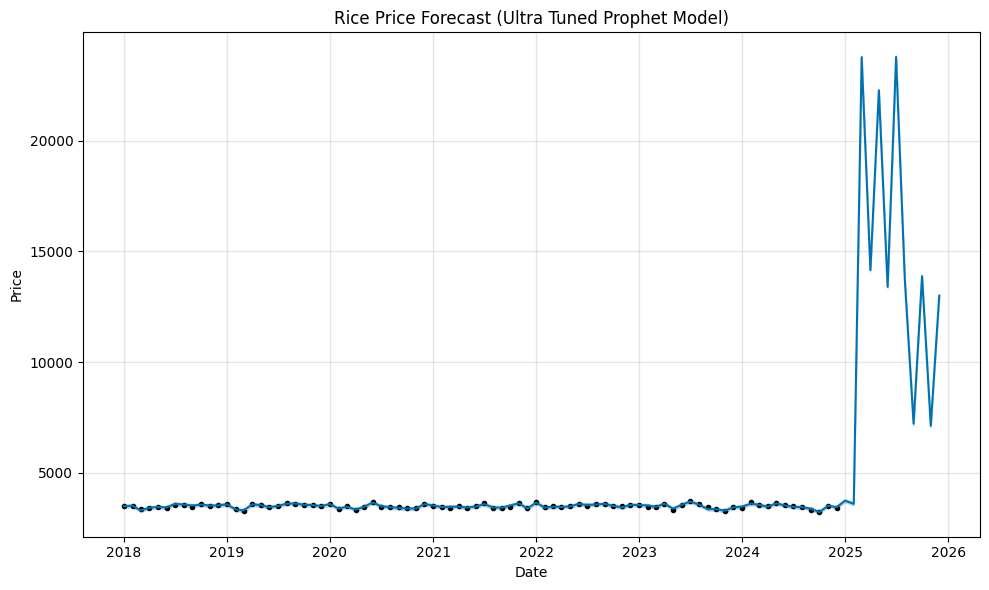

In [13]:
model.plot(forecast)
plt.title("Rice Price Forecast (Ultra Tuned Prophet Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


## 11. Plot components

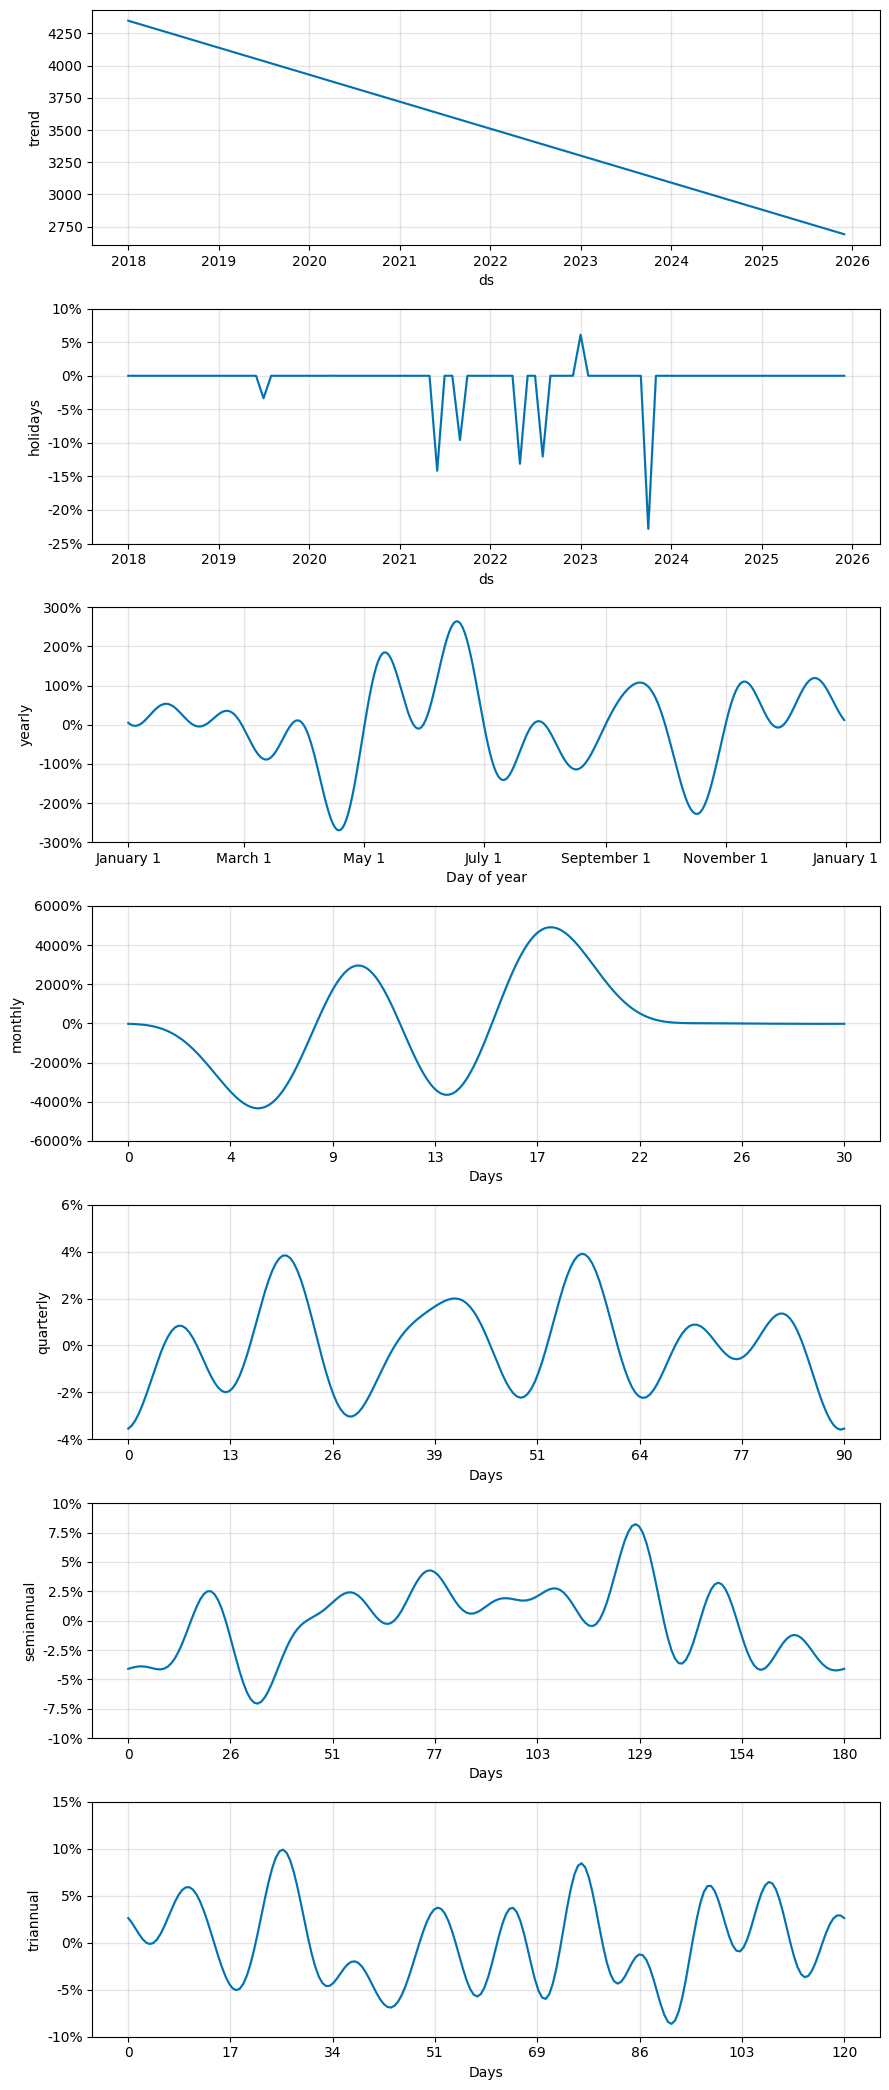

In [14]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()


## 12. Plot actual vs predicted

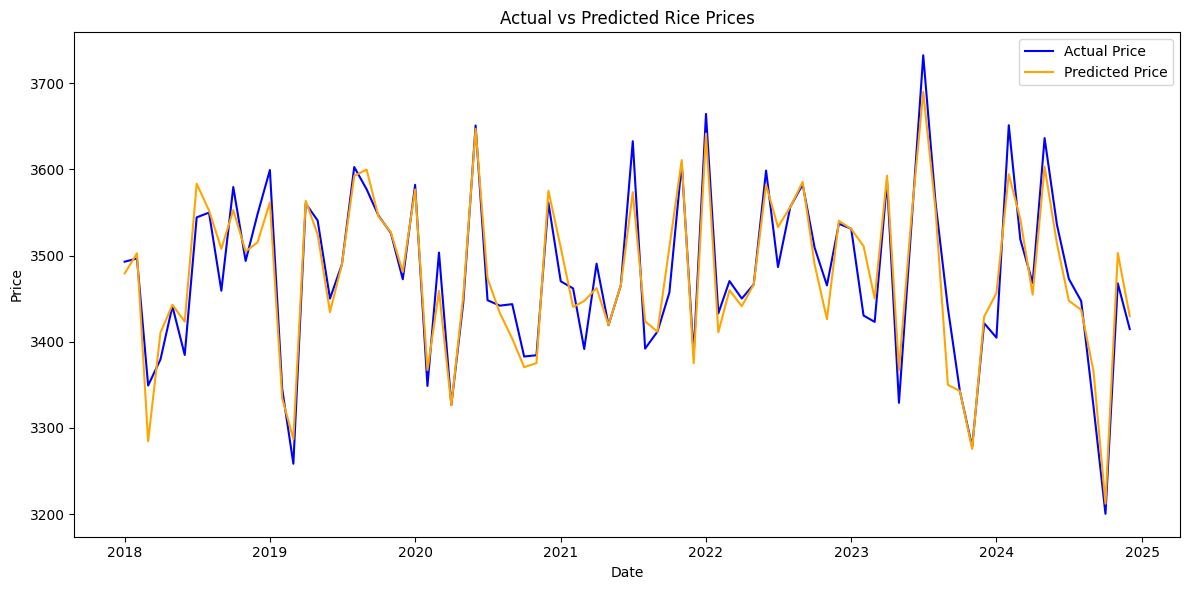

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual['y'], label='Actual Price', color='blue')
plt.plot(actual.index, predicted, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Rice Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
